<h1 align="center">CS51 Final Project:</h1>
<h2 align="center">Restricted Boltzmann Machines and Deep Belief Networks</h2>
<h3 align="center">By Angela Fan, Andre Nguyen, Vincent Nguyen, and George Zeng</h3>

In [65]:
Image(url='http://i2.kym-cdn.com/photos/images/facebook/000/531/557/a88.jpg')

##Imports

In [1]:
%matplotlib inline

from __future__ import absolute_import, print_function, unicode_literals, division
from IPython.display import Image
from sklearn.datasets import fetch_mldata, fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random as rand
import copy
from pylab import rcParams

##Toy Datatset of Movie Ratings

In [2]:
alice = {"Interstellar":1, "Whiplash":1, "Selma":0, "Lego Movie":0, "Birdman":0}
eric = {"Interstellar":0, "Whiplash":0, "Selma":0, "Lego Movie":1, "Birdman":0}
nancy = {"Interstellar":1, "Whiplash":1, "Selma":1, "Lego Movie":0, "Birdman":1}
sarah = {"Interstellar":0, "Whiplash":1, "Selma":0, "Lego Movie":0, "Birdman":1}
mike = {"Interstellar":1, "Whiplash":1, "Selma":1, "Lego Movie":1, "Birdman":1}
bob = {"Interstellar":0, "Whiplash":1, "Selma":1, "Lego Movie":0, "Birdman":1}

data = {"alice":alice, "eric":eric, "nancy":nancy}#, "sarah":sarah} "mike":mike, "bob":bob}

data = pd.DataFrame.from_dict(data)
data.head()

,alice,eric,nancy
Birdman,0,0,1
Interstellar,1,0,1
Lego Movie,0,1,0
Selma,0,0,1
Whiplash,1,0,1


In [3]:
data_array = np.array(data)
print(data_array)
print(data_array.shape)

[[0 0 1]
 [1 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 1]]
(5, 3)


##RBM Implementation

In [3]:
class RBM(object):
    """
    Implementation of Restricted Boltzmann Machine for binary prediction
    
    Inputs:
    Data
    Number of hidden and visible states
    Learning rate, default set to 0.1
    Number of Epochs to train for
    Option for which unit to use, either "binary" or "continuous"
    
    Outputs:
    Weight matrix
    Epoch number and error
    """

    def __init__(self, data, num_visible, num_hidden, num_epochs, learning_rate=0.1, unit="binary"):
        
        self.data = data
        self.num_data = data.shape[0]
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.unit = unit

        # weight matrix first row and first column represent the bias
        self.weights = np.random.rand(self.num_visible, self.num_hidden) 
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
        
    def _relu(self, x):
        """
        Rectifier continuous Activation Function
        """
        return np.maximum(0,x)
        
    def _sigmoid(self, x):
        """
        Sigmoid Binary Activation function
        """
        return 1.0/(1.0+np.exp(-x))
    
    def _gen_prob(self,a,b):   
        if self.unit == "binary":
            return self._sigmoid(np.dot(a,b))
        elif self.unit == "continuous":
            return self._relu(np.dot(a,b))
        else:
            raise "Unknown Unit"
    
    def _gen_assoc(self,a):
        probs = (self._gen_prob(a,self.weights))
        #print(probs)
        return np.dot(a.T,probs)
    
    def _sample_v_given_h(self, h):  # h does not contain bias
        probs = self._gen_prob(self.weights, np.insert(h,0,1))        
        if self.unit == "binary":
            sample = probs > np.random.rand(self.num_visible + 1)
        elif self.unit == "continuous":
            sample = probs + np.random.randn(self.num_visible + 1)
        return sample[1:]
    
    def _sample_h_given_v(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1, axis = 1).T)
        if self.unit == "binary":
            sample = probs > np.random.rand(self.num_hidden + 1, self.num_data)
        elif self.unit == "continuous":
            sample = probs + np.random.randn(probs.shape[0], probs.shape[1])
        return sample[1:].T
    
    def _sample_h_given_v_nontrain(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1).T)      
        if self.unit == "binary":
            sample = probs > np.random.rand(self.num_hidden + 1)
        elif self.unit == "continuous":
            sample = probs + np.random.randn(self.num_hidden + 1)
        return sample[1:]
    
    def CDk(self):
        """
        Implementation of CD-k iterative training algorithm
        """
        max_epochs = self.num_epochs + 1
        
        # array to keep track of errors for plotting
        error_array = []
        
        # insert the bias layer into the data
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        # iterate for each epoch
        for epoch in xrange(0, max_epochs):
            
            # CD-k positive phase
            up_probs = self._gen_prob(self.data,self.weights)
            up_associations = self._gen_assoc(self.data)
            if self.unit == "binary":
                up_states = up_probs > np.random.rand(self.num_data, self.num_hidden + 1)
            elif self.unit == "continuous":
                up_states = up_probs + np.random.randn(up_probs.shape[0], up_probs.shape[1])
            
            # CD-k negative phase
            down_probs = self._gen_prob(up_states,self.weights.T)
            down_probs[:,0] = 1 
            down_associations = self._gen_assoc(down_probs)
            
            # Update weights iteratively based on positive and negative phases
            self.weights += self.learning_rate * \
                ((up_associations - down_associations)/self.num_data)
                                
            # Calculate error
            error = np.sum((self.data - down_probs) ** 2)
            
            error_array.append(error)

            # Print information about the last epoch
            if epoch == self.num_epochs:
                print("Layers: ", self.num_hidden, "Rate: ", self.learning_rate, "Epoch: ", epoch, ", Error: ", error)
                return down_probs, error_array
            
    def train(self, up_probs, error_array, epoch):
        """
        Trains the RBM, calling CDk or PCDk depending on user input
        """
        up_associations = self._gen_assoc(self.data)
        if self.unit == "binary":
            up_states = up_probs > np.random.rand(self.num_data, self.num_hidden + 1)
        elif self.unit == "continuous":
            up_states = up_probs + np.random.randn(up_probs.shape[0], up_probs.shape[1])

        # CD-k negative phase
        down_probs = self._gen_prob(up_states,self.weights.T)
        down_probs[:,0] = 1 
        down_associations = self._gen_assoc(down_probs)

        # Update weights iteratively based on positive and negative phases
        self.weights += self.learning_rate * \
            ((up_associations - down_associations)/self.num_data)

        # Calculate error
        error = np.sum((self.data - down_probs) ** 2)

        error_array.append(error)
        
        return down_probs, error
    
    def PCDk(self):
        """
        Implementation of Persistent CD-k iterative training algorithm
        
        aims to sample almost directly from the model distribution to better approximate
        the likelihood gradient when the mixing is low
        
        Based on this work: http://www.cs.toronto.edu/~tijmen/pcd/pcd.pdf
        """
        max_epochs = self.num_epochs + 1
        
        # array to keep track of errors for plotting
        error_array = []
        
        down_probs = []
        
        # insert the bias layer into the data
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        # iterate for each epoch
        for epoch in xrange(0, max_epochs):
            
            # CD-k positive phase
            if epoch == 0:
                up_probs = self._gen_prob(self.data,self.weights)
            else:
                up_probs = self._gen_prob(down_probs,self.weights)
                
            down_probs, error = self.train(up_probs, error_array, epoch)
            
            # Print information about the last epoch
            if epoch == self.num_epochs:
                print("Layers: ", self.num_hidden, "Rate: ", self.learning_rate, "Epoch: ", epoch, ", Error: ", error)
                return down_probs, error_array


##Fetch MNIST Dataset

In [19]:
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)
print(mnist.data.shape)

(70000, 784)


#### Example Image

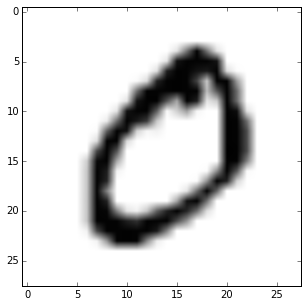

In [20]:
data_array = mnist.data
plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

#### Standard basic RBMs take binary inputs only, so we'll convert the image to a binary matrix

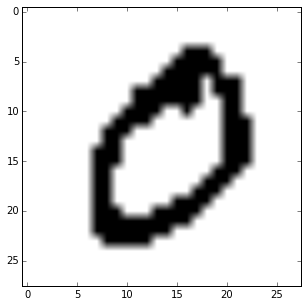

In [21]:
for img in data_array:
    # set arbitrary, reasonable cutoff
    img[img < 100] = 0
    img[img > 0] = 1

# sample image after converting to binary matrix
plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

#### Run RBM on MNIST dataset- Binary

In [60]:
visible_units = data_array.shape[1]
epochs = 10
hidden_units = 100
learning_rate = 0.1

r = RBM(data_array, visible_units, hidden_units, epochs, learning_rate, "binary")
sample, error = r.CDk()
print(r.weights)

Layers:  100 Rate:  0.1 Epoch:  10 , Error:  5875823.91069
[[ 0.11134249  0.00294052 -0.01300772 ...,  0.00106157 -0.00470908
  -0.006305  ]
 [-0.05032108 -0.49213499  0.0398472  ..., -0.37152426  0.13562119
  -0.42069932]
 [-0.05041215  0.12357339 -0.2079445  ..., -0.5299373   0.09260831
   0.12360469]
 ..., 
 [-0.05101434  0.15507701  0.33747953 ...,  0.31762844  0.24827861
  -0.53617701]
 [-0.05024257 -0.56361156  0.29681684 ..., -0.39320578 -0.28608538
  -0.01105544]
 [-0.05029308 -0.26031837  0.11849238 ...,  0.19891894 -0.53985023
  -0.33148175]]


#### Run RBM on MNIST dataset- Continuous

In [61]:
visible_units = data_array.shape[1]
epochs = 10
hidden_units = 100
learning_rate = 10 ** (-10)

r = RBM(data_array, visible_units, hidden_units, epochs, learning_rate, "continuous")
sample, error = r.CDk()
print(r.weights)

Layers:  100 Rate:  1e-10 Epoch:  10 , Error:  4.07587340469e+12
[[  0.00000000e+00  -1.37705397e-04  -1.41398135e-04 ...,  -1.45785416e-04
   -1.48483514e-04  -1.43966592e-04]
 [  0.00000000e+00   2.01407457e-02   5.59102050e-01 ...,   5.40224391e-02
    3.99801488e-01  -2.38881035e-01]
 [  0.00000000e+00  -3.73549405e-02  -7.84686853e-02 ...,   2.86247265e-01
    6.44716332e-01   2.64400385e-01]
 ..., 
 [  0.00000000e+00  -1.42927113e-01   5.85230782e-01 ...,  -1.23902654e-01
    4.72986286e-01   6.03004354e-02]
 [  0.00000000e+00   3.52275992e-01   5.38799316e-01 ...,  -1.31911872e-01
    3.86203976e-01   5.45647289e-01]
 [  0.00000000e+00  -1.09535928e-01   4.28498344e-01 ...,   2.56604405e-01
    3.55557317e-01  -2.10463197e-01]]


## Parameter Optimization using Cross Validation 

In [6]:
visible_units = data_array.shape[1]
max_epochs = 100
max_hidden_layers = 11
max_learning_rate = 10

# cross validation
for hidden_layers in xrange(1, max_hidden_layers):
    for learning_rate in xrange(1, max_learning_rate):
        r = RBM(data_array, visible_units, 100*hidden_layers, max_epochs, learning_rate/float(10))
        r.CDk()

Layers:  100 Rate:  0.1 Epoch:  100 , Error:  2924093.40296
Layers:  100 Rate:  0.2 Epoch:  100 , Error:  2590810.49885
Layers:  100 Rate:  0.3 Epoch:  100 , Error:  2419529.13044
Layers:  100 Rate:  0.4 Epoch:  100 , Error:  2953467.43609
Layers:  100 Rate:  0.5 Epoch:  100 , Error:  3080931.4865
Layers:  100 Rate:  0.6 Epoch:  100 , Error:  4649189.5418
Layers:  100 Rate:  0.7 Epoch:  100 , Error:  13714638.9772
Layers:  100 Rate:  0.8 Epoch:  100 , Error:  7172705.9948
Layers:  100 Rate:  0.9 Epoch:  100 , Error:  2575479.49496
Layers:  200 Rate:  0.1 Epoch:  100 , Error:  2379539.26787
Layers:  200 Rate:  0.2 Epoch:  100 , Error:  2171885.90979
Layers:  200 Rate:  0.3 Epoch:  100 , Error:  2084536.22896
Layers:  200 Rate:  0.4 Epoch:  100 , Error:  2846840.70569
Layers:  200 Rate:  0.5 Epoch:  100 , Error:  3097520.46994
Layers:  200 Rate:  0.6 Epoch:  100 , Error:  4288084.20697
Layers:  200 Rate:  0.7 Epoch:  100 , Error:  13712224.226
Layers:  200 Rate:  0.8 Epoch:  100 , Error:

In [8]:
cv = pd.read_csv("crossval.csv")
cv.head()

,Hidden Units,Learning Rate,Error
0,100,0.1,2924093.403
1,100,0.2,2590810.499
2,100,0.3,2419529.130
3,100,0.4,2953467.436
4,100,0.5,3080931.487


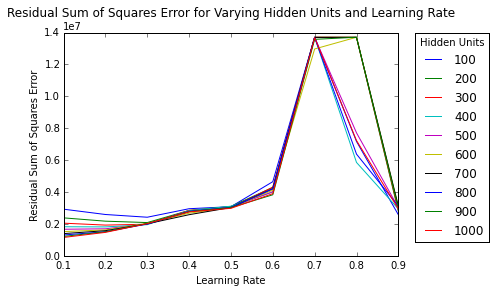

In [9]:
for key, grp in cv.groupby(['Hidden Units']):
    plt.plot(grp['Learning Rate'], grp['Error'], label=key)

plt.legend(title='Hidden Units',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Residual Sum of Squares Error for Varying Hidden Units and Learning Rate', y=1.05)
plt.xlabel('Learning Rate')
plt.xlim([0.1, 0.9])
plt.ylabel('Residual Sum of Squares Error') 
plt.show()

## Visualizing our RBM Output

In [52]:
def net_and_plot(data, num_hidden, epochs, dataset, \
                 learning_rate=.3, unit="binary", \
                 persistent=False, net="RBM", \
                 images= [11, 12002, 15005, 19005, 28005, 32005, 39007, 43004, 49010, 58030]):
    """
    Trains and plots RBM output on MNIST dataset
    
    Inputs:
    data 
    number of hidden states
    number of epochs
    RBM learning rate, default set to 0.3
    
    Outputs:
    Trained RBM weight matrix
    Example of RBM prediction on an example digit from the MNIST dataset
    Graph of error as a function of epoch
    """
    
    # Set up RBM
    num_visible = data.shape[1]
    
    if net == "RBM":
        r = RBM(data, num_visible, num_hidden, epochs, learning_rate, unit)
        # Train RBM
        if persistent == True:
            sample = r.PCDk()
        else:
            sample = r.CDk()
    else: 
        r = DBN(data, [num_visible,50,20], epochs, learning_rate, "binary", verbose=False)
        r._build()
    
    if dataset == "MNIST":
        f = plt.subplots(10,5, figsize=(15,15))
        iter1 = 10
        color = "Greys"
        shape = [28, 28]
    elif dataset == "Faces":
        f = plt.subplots(6,5, figsize=(15,15))
        iter1 = 6
        color = plt.cm.gray
        shape = [62, 47]
    else:
        print("Sorry, not a known dataset")

    # Set up subplots and titles for the columns
    f[1][0,0].set_title("Original Image", fontsize=18).set_position([.5, 1.35])
    f[1][0,1].set_title(net + " Probabilities", fontsize=18).set_position([.5, 1.35])
    f[1][0,2].set_title(net + " Sample 1", fontsize=18).set_position([.5, 1.35])
    f[1][0,3].set_title(net + " Sample 2", fontsize=18).set_position([.5, 1.35])
    f[1][0,4].set_title(net + " Sample 3", fontsize=18).set_position([.5, 1.35])    
    
    # Iterate over digits/faces
    for i in xrange(0, iter1):
        
        if net == "DBN":
            h = r._dbn_sample_h_given_v(data_array[images[i]])
            v = r._dbn_sample_v_given_h(h)
        
        # Iterate over columns
        for j in xrange(0, 5):
            
            # First column is original image
            if j == 0:
                f[1][i, j].imshow(data[images[i]].reshape(shape[0], shape[1]), cmap=color)
            # Second column is RBM prediction
            elif j == 1:
                if net == "DBN":
                    f[1][i, j].imshow(v.reshape(shape[0],shape[1]), cmap=color)
                else:
                    f[1][i, j].imshow(sample[0][images[i]][1:].reshape(shape[0], shape[1]), cmap=color)            
            # Third to Fifth columns are RBM samples
            else:
                if net == "DBN":
                    s = v.reshape(28,28)
                else:
                    s = sample[0][images[i]][1:].reshape(shape[0],shape[1])
                
                if unit == "binary":
                    img = s > np.random.rand(s.shape[0], s.shape[1]) 
                elif unit == "continuous":
                    img = s + np.random.randn(s.shape[0], s.shape[1])
                f[1][i, j].imshow(img, cmap="Greys")

            # Get rid of useless axes
            f[1][i, j].get_xaxis().set_visible(False)
            f[1][i, j].get_yaxis().set_visible(False)

    plt.suptitle(net + " Trained on " + dataset + " Dataset", fontsize=25)
    plt.show()
    
    # Plot error linegraph
    if net == "RBM":
        rcParams['figure.figsize'] = 5, 5
        err = sample[1]
        plt.plot(err)
        plt.yscale('log')
        plt.ylabel("Error")
        plt.xlabel("Epoch")
        plt.title("Error over Epochs")
        plt.show()
    
        return r.weights

#### Testing Visualization Function

Layers:  100 Rate:  0.4 Epoch:  5 , Error:  8156386.61232


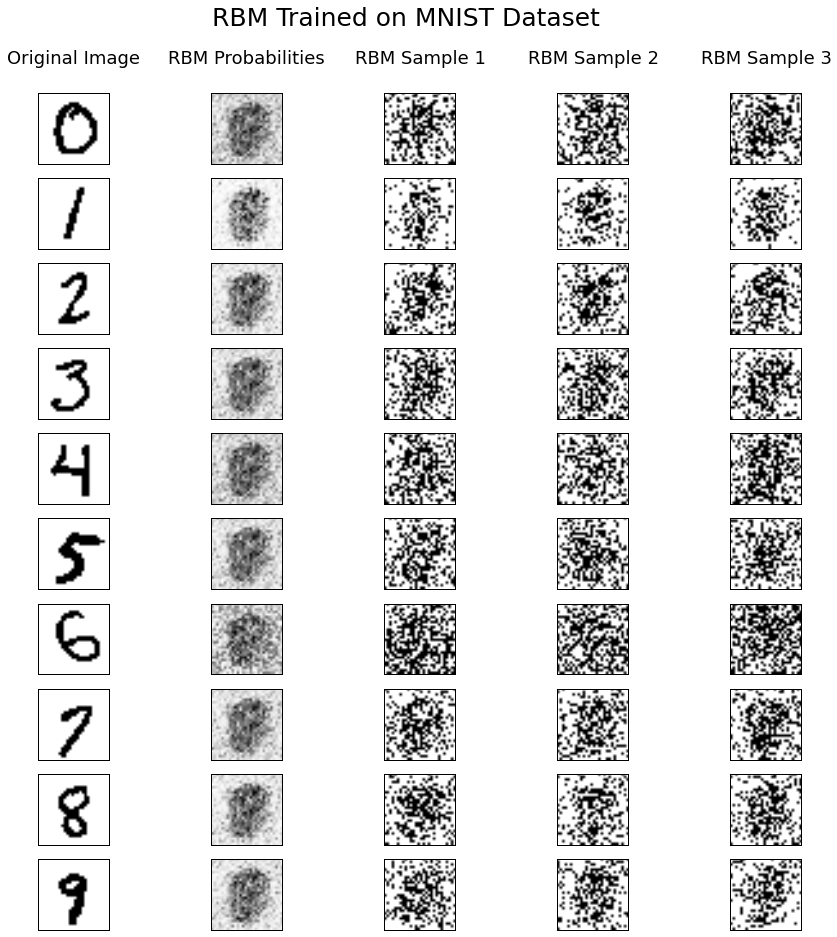

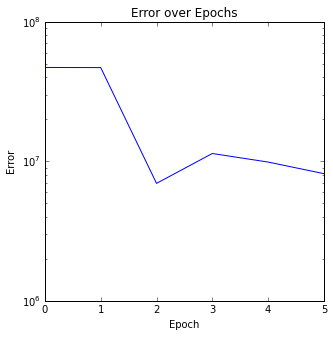

array([[ 0.0008078 ,  0.0379971 , -0.06933708, ..., -0.1258482 ,
        -0.04781505, -0.13099452],
       [-0.2       ,  0.06789881, -0.51189724, ..., -0.14897623,
        -0.49820563,  0.14116263],
       [-0.2       , -0.26198151, -0.76990201, ..., -0.53404355,
        -0.74585725, -0.65092788],
       ..., 
       [-0.2       , -0.44694045,  0.12521935, ..., -0.5892015 ,
        -0.67658576, -0.44702065],
       [-0.2       , -0.47142485, -0.41357745, ..., -0.79717746,
         0.08197929,  0.05925427],
       [-0.2       ,  0.00734801,  0.13232764, ..., -0.25024731,
        -0.62077379, -0.77579306]])

In [44]:
net_and_plot(data_array, num_hidden=100, epochs=5, dataset="MNIST", learning_rate=0.4, persistent=False, unit="binary", net="RBM")

####Binary Linear Units

Layers:  100 Rate:  0.1 Epoch:  1000 , Error:  1901897.56491


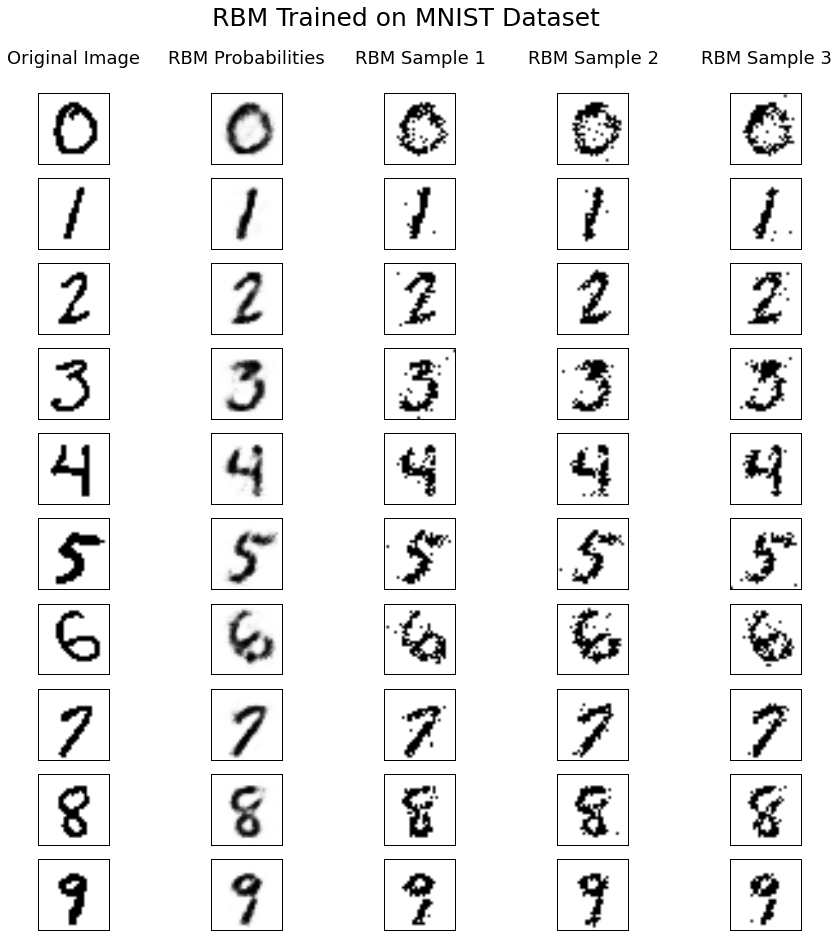

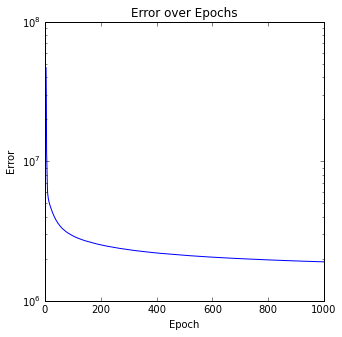

array([[ 2.38350397,  0.94751129,  2.7534052 , ...,  2.10463543,
         1.00502888,  1.06332949],
       [-0.36326772, -0.5379705 , -0.51286061, ...,  0.09885153,
        -0.68404078, -0.21198356],
       [-0.33678388,  0.10095599, -0.19471354, ...,  0.10565443,
         0.00968083, -0.08641277],
       ..., 
       [-0.27277255, -0.2367128 ,  0.11438062, ...,  0.15390482,
        -0.48999884,  0.17297348],
       [-0.3567985 ,  0.05652801, -0.08698196, ..., -0.0057992 ,
        -0.61062198, -0.30776863],
       [-0.35160092,  0.29796841, -0.21187222, ...,  0.21245542,
        -0.01880568, -0.39883002]])

In [59]:
net_and_plot(data_array, num_hidden=100, epochs=1000, learning_rate=0.1, unit="binary", dataset="MNIST")

####Continuous Retifier Linear Units

Layers:  100 Rate:  1e-10 Epoch:  1000 , Error:  169743520798.0


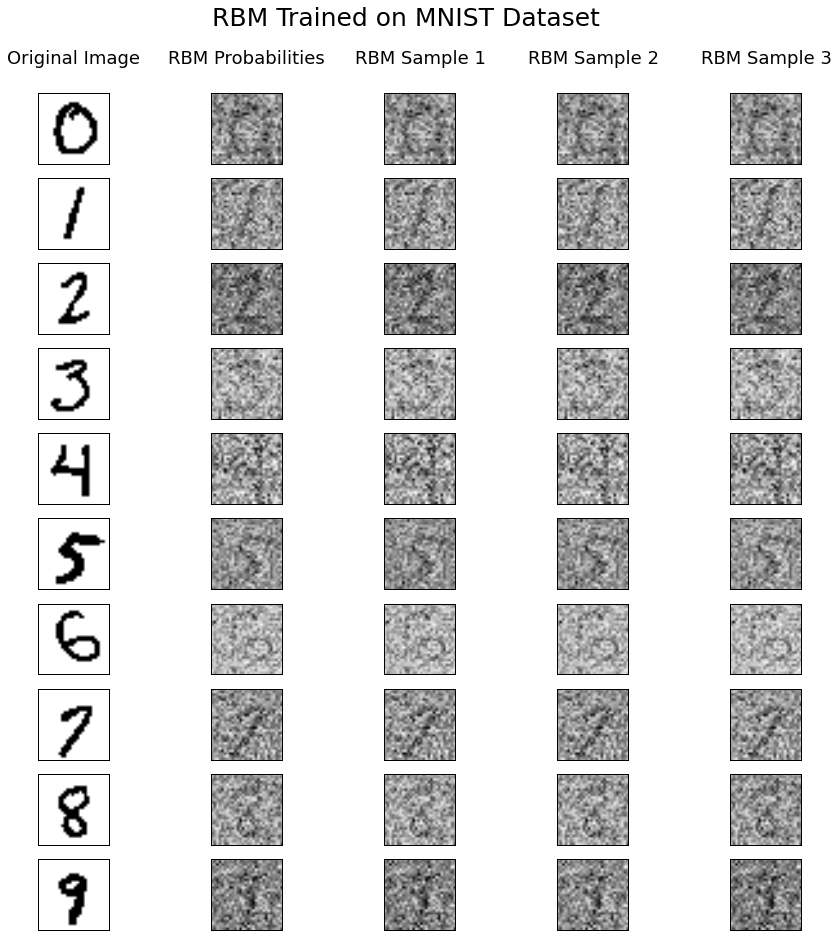

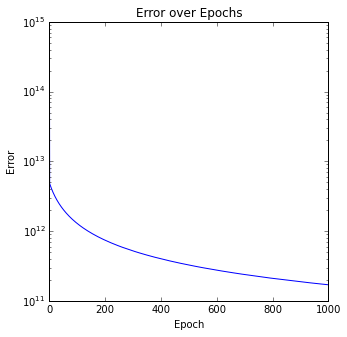

array([[ 0.        , -0.00079161, -0.00077129, ..., -0.00079544,
        -0.00077513, -0.00077995],
       [ 0.        , -0.07053577,  0.43586276, ..., -0.36917095,
         0.50176234,  0.34489912],
       [ 0.        ,  0.00127988,  0.38070129, ...,  0.11929174,
        -0.24729263,  0.29161126],
       ..., 
       [ 0.        ,  0.44499665,  0.23498613, ...,  0.30210623,
        -0.30700533, -0.30809989],
       [ 0.        , -0.21717247, -0.20035716, ...,  0.44987013,
         0.04781243, -0.12337666],
       [ 0.        ,  0.47766708, -0.26427348, ..., -0.18533338,
         0.13441406, -0.03438451]])

In [58]:
net_and_plot(data_array, num_hidden=100, epochs=1000, learning_rate=(10**(-10)), unit="continuous", dataset="MNIST")

#### Binary with Persistent CDk

####(Run on 10 epochs)

Layers:  100 Rate:  0.1 Epoch:  10 , Error:  9168980.26468


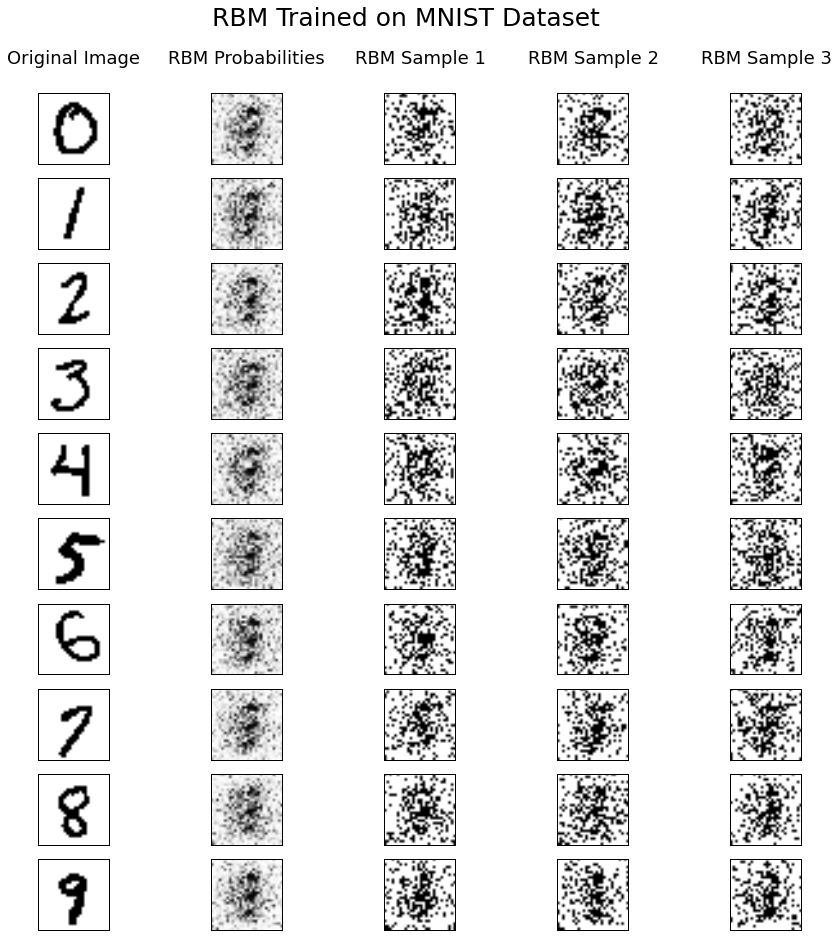

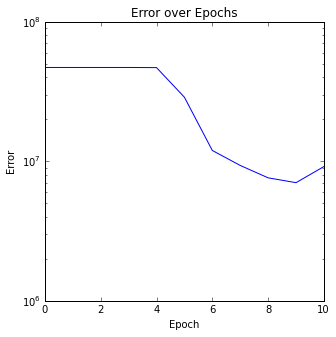

array([[ 0.10080354, -0.01918392,  0.01127631, ...,  0.01697823,
        -0.01527468, -0.01418059],
       [-0.05043114,  0.08196349, -0.38494727, ..., -0.06450841,
        -0.35247161, -0.43221117],
       [-0.05008144, -0.52323129, -0.42892214, ..., -0.26225629,
         0.36488916,  0.15466495],
       ..., 
       [-0.05005001,  0.20497422,  0.25473179, ...,  0.27698032,
        -0.51179554, -0.34604273],
       [-0.05006531, -0.2305665 , -0.181702  , ...,  0.14597708,
        -0.27286846, -0.28903384],
       [-0.05052109, -0.08079798,  0.43184722, ...,  0.28427287,
         0.27787647, -0.30636089]])

In [12]:
net_and_plot(data_array, dataset="MNIST", num_hidden=100, epochs=10, learning_rate=0.1, unit="binary", persistent=True)

##Fetch FACES Dataset

In [25]:
lfw_people = fetch_lfw_people(min_faces_per_person=70)
print(lfw_people.data.shape)
print(lfw_people.images.shape)

(1288, 2914)
(1288, 62, 47)


####Example Image

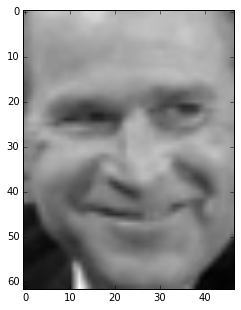

In [26]:
faces_data_array = lfw_people.data
person = lfw_people.target
names = lfw_people.target_names

plt.imshow(faces_data_array[909].reshape(62,47), cmap=plt.cm.gray)
#plt.title(names[person][0])
plt.show()

#### Run RBM on FACES dataset-Continuous

In [15]:
visible_units = faces_data_array.shape[1]
epochs = 10
hidden_units = 100
learning_rate = .1#10 ** (-10)

r = RBM(faces_data_array, visible_units, hidden_units, epochs, learning_rate, "continuous")
sample, error = r.CDk()
print(r.weights)

Layers:  100 Rate:  0.1 Epoch:  10 , Error:  3.89994194928e+40
[[  0.00000000e+00  -1.38878511e+09  -1.40766940e+09 ...,  -1.40563241e+09
   -1.39618636e+09  -1.37680909e+09]
 [  0.00000000e+00  -1.35745584e+16  -1.37591388e+16 ...,  -1.37392304e+16
   -1.36469001e+16  -1.34574997e+16]
 [  0.00000000e+00  -1.20227483e+16  -1.21862278e+16 ...,  -1.21685954e+16
   -1.20868200e+16  -1.19190714e+16]
 ..., 
 [  0.00000000e+00  -1.41322341e+16  -1.43243975e+16 ...,  -1.43036712e+16
   -1.42075477e+16  -1.40103663e+16]
 [  0.00000000e+00  -1.26918821e+16  -1.28644603e+16 ...,  -1.28458465e+16
   -1.27595198e+16  -1.25824351e+16]
 [  0.00000000e+00  -1.38246556e+16  -1.40126366e+16 ...,  -1.39923615e+16
   -1.38983300e+16  -1.37054401e+16]]


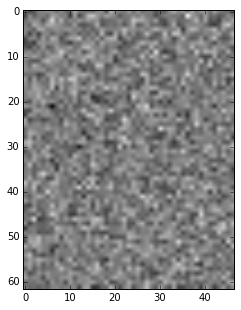

In [16]:
plt.imshow(sample[0][1:].reshape(62, 47), cmap=plt.cm.gray)
plt.show()

##Visualization of RBM FACES Output

####Continuous Linear Retifier Units

Layers:  10 Rate:  1e-17 Epoch:  1000 , Error:  3.17335471553e+16


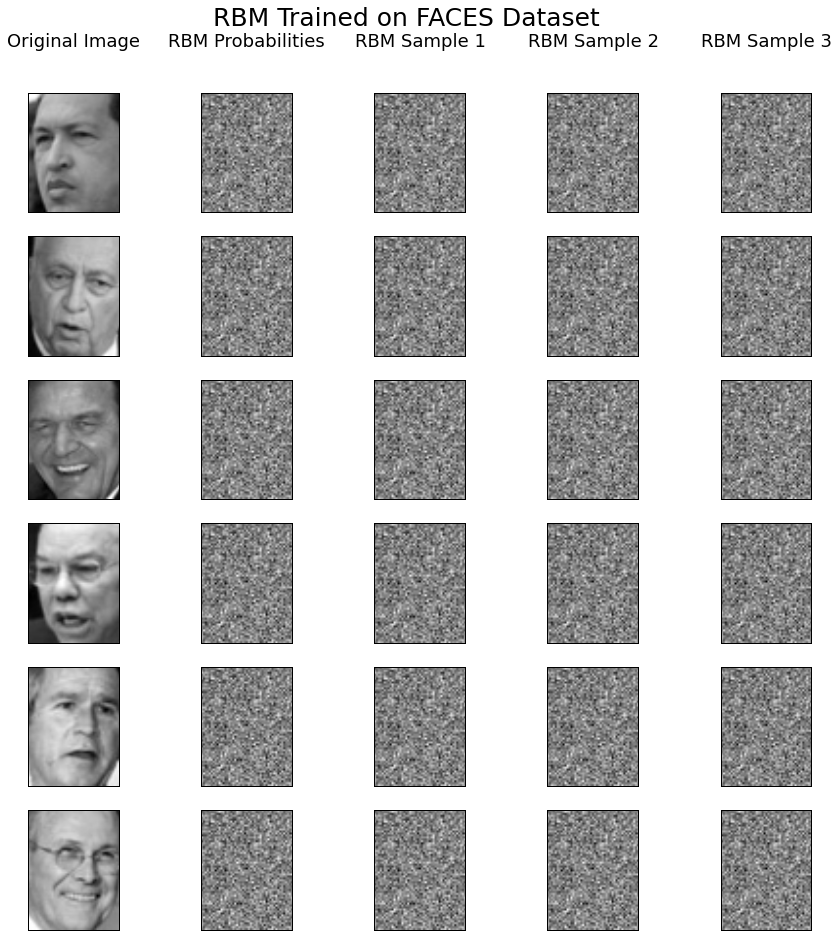

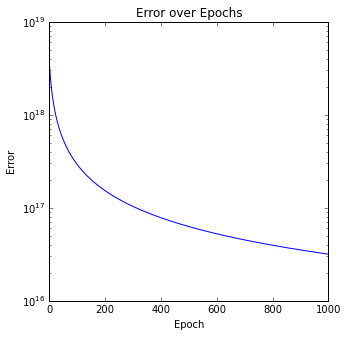

array([[  0.00000000e+00,  -1.15088062e-06,  -1.16404391e-06, ...,
         -1.17081571e-06,  -1.14754443e-06,  -1.15358730e-06],
       [  0.00000000e+00,   3.70762222e-02,  -1.28330373e-01, ...,
          5.85059666e-01,  -1.43366103e-02,  -1.38854341e-01],
       [  0.00000000e+00,   1.14838609e-01,   2.37030176e-01, ...,
          4.13133871e-01,   6.41093025e-01,   4.74691286e-02],
       ..., 
       [  0.00000000e+00,   4.25565620e-01,   4.54892070e-01, ...,
         -1.30595805e-01,   1.20495463e-01,   4.22718291e-01],
       [  0.00000000e+00,   8.48925630e-02,  -2.16741486e-01, ...,
          4.09075639e-01,  -7.94502678e-02,   4.02126513e-01],
       [  0.00000000e+00,   4.53925120e-01,   3.03543593e-01, ...,
         -1.76552895e-01,   4.54231369e-01,  -1.95151359e-01]])

In [45]:
net_and_plot(faces_data_array, dataset="Faces", num_hidden=10, epochs=1000, learning_rate=(10**(-17)), images = [0, 9, 301, 500, 600, 801, 902,2,3,4])

Layers:  10 Rate:  1e-17 Epoch:  20 , Error:  72205850814.0


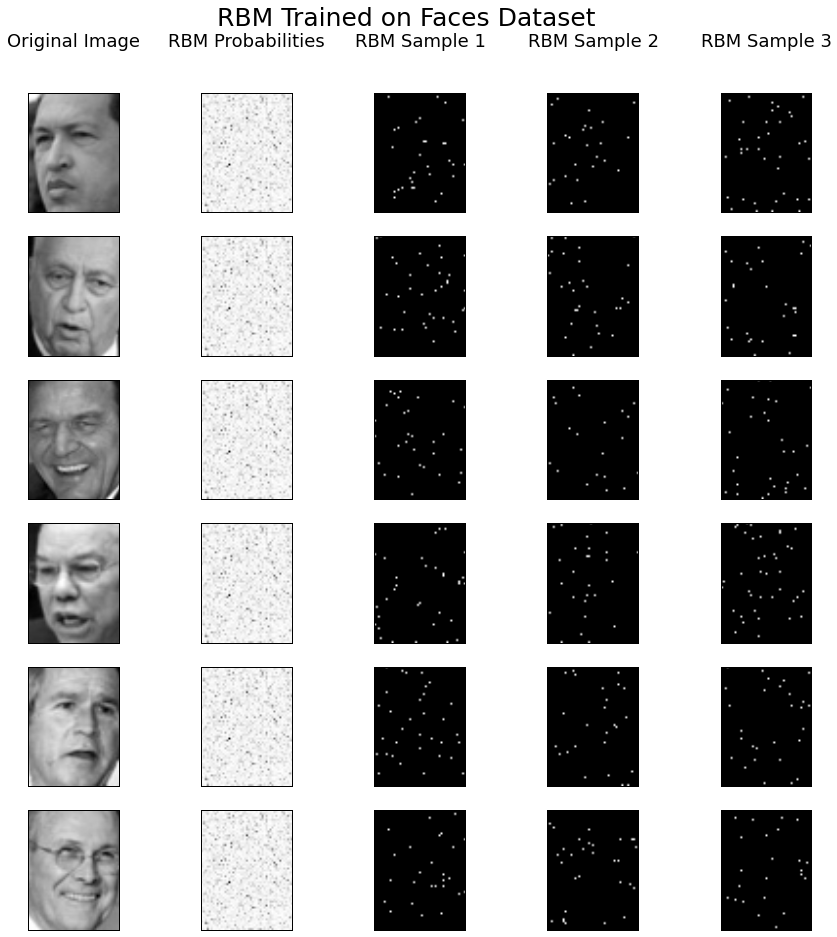

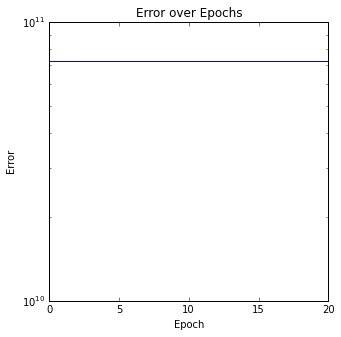

array([[  1.35896287e-25,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.39562656e-15,   5.78476934e-03,   1.51957305e-01, ...,
          5.85810226e-01,   4.68026410e-01,   9.01733146e-02],
       [  9.54937991e-15,   2.06831119e-01,   7.72428196e-01, ...,
          7.77068642e-01,   3.03032524e-01,   8.31188648e-01],
       ..., 
       [  1.23849093e-14,   8.03332024e-01,   9.48814544e-01, ...,
          3.61720404e-01,   3.77506268e-01,   2.69863892e-01],
       [  1.18111172e-14,   3.85742643e-01,   4.19180686e-01, ...,
          2.84140159e-02,   9.27285358e-02,   7.88075952e-01],
       [  1.11084493e-14,   2.57885697e-01,   4.83891209e-01, ...,
          1.58458344e-01,   4.46455747e-01,   4.73548585e-01]])

In [45]:
net_and_plot(faces_data_array, dataset="Faces", num_hidden=10, epochs=20, learning_rate=(10**(-17)), images = [0, 9, 301, 500, 600, 801, 902,2,3,4])

##Deep Belief Network

### Stacking RBMs to perform deep learning

In [46]:
class DBN(object):
    """
    Implementation of Deep Belief Network, made by stacking RBMs
    
    Inputs:
    data
    layer_nodes, an array that describes desired network architecture
    
    Example:
    [3, 4, 5, 3] will form a DBN with:
    - 3 unit visible layer
    - 4 unit hidden layer 
    - 5 unit hidden layer
    - 3 unit hidden layer
    
    number of epochs to train from
    learning rate, default set to 0.1
    unit, either "binary" or "continuous", default set to binary
    
    Outputs:
    set of weights
    """

    def __init__(self, data, layer_nodes, num_epochs, learning_rate=0.1, unit="binary", verbose="true"):
        
        self.data = data
        self.num_data = data.shape[0]
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.layer_nodes = layer_nodes
        self.num_layers = len(self.layer_nodes)
        self.unit = unit
        self.verbose = verbose
        
        # List of stacked RBMs
        self.RBM_layer = range(0,len(self.layer_nodes)-1)  
        
        # List of messages 
        self.RBM_layer_messages = range(0,len(self.layer_nodes))  
        self.RBM_layer_messages[0] = self.data
        
    def _build(self):
        """
        Builds the DBN
        """
                
        for i in xrange(0,len(self.layer_nodes)-1):
            
            # create each RBM layer by creating separate RBM objects
            self.RBM_layer[i] = RBM(self.RBM_layer_messages[i], \
                                    self.layer_nodes[i], \
                                    self.layer_nodes[i+1], \
                                    self.num_epochs, \
                                    self.learning_rate, \
                                    self.unit)
            
            # train each RBM layer using RBM implementation of CDk
            down_probs, err = self.RBM_layer[i].CDk()  
            
            # create messages to pass between the layers
            self.RBM_layer_messages[i+1] = self.RBM_layer[i]._sample_h_given_v(self.RBM_layer_messages[i])
            
            # error
            if self.verbose=='true':
                print(i)
                print(self.RBM_layer_messages[i])
                print(down_probs[:,1:])
            error = np.sum((self.RBM_layer_messages[i] - down_probs[:,1:]) ** 2)
                #print("DBN Layer: ", i, ", DBN Error: ", error)
            
        return
    
    def _dbn_sample_v_given_h(self, h):  
        # h does not contain bias
        
        temp = h
        for i in xrange(len(self.layer_nodes)-2,-1,-1):
            temp = self.RBM_layer[i]._sample_v_given_h(temp)
        return temp
    
    def _dbn_sample_h_given_v(self, v):  
        # v does not contain bias
        
        temp = v
        for i in xrange(0,len(self.layer_nodes)-1):
            temp = self.RBM_layer[i]._sample_h_given_v_nontrain(temp)
        return temp


#### Run DBN on MNIST Dataset-Binary

In [75]:
visible_units = data_array.shape[1]
num_epochs = 100
learning_rate = .1#10 ** (-10)

dbn_learner = DBN(data_array, [visible_units,50,20], num_epochs, learning_rate, "binary")
dbn_learner._build()

Layers:  50 Rate:  0.1 Epoch:  2 , Error:  47051242.4147
0
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[ 0.9999972   0.99999982  0.99999958 ...,  0.99999997  0.99999779
   0.9999999 ]
 [ 0.9999972   0.99999982  0.99999958 ...,  0.99999997  0.99999779
   0.9999999 ]
 [ 0.9999972   0.99999982  0.99999958 ...,  0.99999997  0.99999779
   0.9999999 ]
 ..., 
 [ 0.9999972   0.99999982  0.99999958 ...,  0.99999997  0.99999779
   0.9999999 ]
 [ 0.9999972   0.99999982  0.99999958 ...,  0.99999997  0.99999779
   0.9999999 ]
 [ 0.9999972   0.99999982  0.99999958 ...,  0.99999997  0.99999779
   0.9999999 ]]
Layers:  20 Rate:  0.1 Epoch:  2 , Error:  4.20014898815
1
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  T

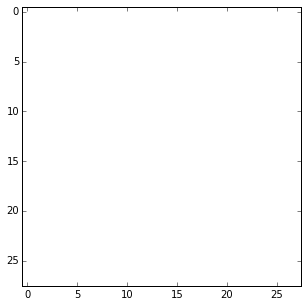

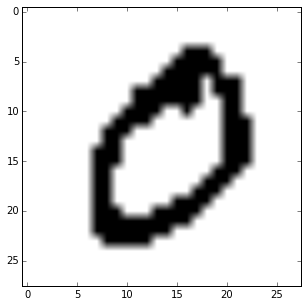

In [76]:
img = 0

h = dbn_learner._dbn_sample_h_given_v(data_array[img])
v = dbn_learner._dbn_sample_v_given_h(h)

plt.imshow(v.reshape(28,28), cmap = 'Greys')
plt.show()

plt.imshow(data_array[img].reshape(28,28), cmap = 'Greys')
plt.show()

## Visualizing on DBN MNIST Output

####Binary Linear Units

In [ ]:
net_and_plot(data_array, num_hidden=100, epochs=2, dataset="MNIST", learning_rate=.1, unit="binary", persistent=False, net="DBN")

####Continuous Linear Units

In [ ]:
dbn_and_plot(data_array, 1000, learning_rate=10**(-10), unit="continuous", verbose="false")